# Density Estimation with Neural ODEs

`torchdyn` allows for easy implementation of density estimation models. Continuous normalizing flows (CNFs) sidestep architectural restrictions of discrete flows, necessary to preserve tractability of Jacobian log-determinants. This is achieved by leveraging a computationally cheaper divergence obtainable by a change of variable in continuous-depth, turning 

. The flow is normalized by the instantaneous divergence to preserve the integral norm of the density throughout the dynamics. We refer to this excellent tutorial and survey for an in-depth introduction.

This notebooks shows a regular continuous normalizing flow [CNF](https://arxiv.org/abs/1806.07366), implemented with a few lines of `torchdyn`.

In [13]:
import sys

sys.path.append('..')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *

**Data**: we use a standard N-gaussians dataset. The data is z-normalized for easier training.

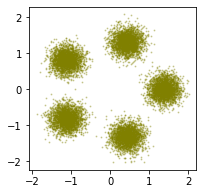

In [22]:
data = ToyDataset()
n_samples = 1 << 14
n_gaussians = 7

X, yn = data.generate(n_samples // n_gaussians, 'gaussians', n_gaussians=5, std_gaussians=0.15, dim=2, radius=3)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c='olive', alpha=0.3, s=1)

In [23]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn).long().to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True) 

## Continuous Normalizing Flow

First, we show a minimal implementation of a standard *continuous normalizing flow* (`CNF`). This exercise showcases the flexibility of `torchdyn`: a `CNF` can be defined as nothing more than a wrap for any module, handling the additional dimension dedicated to the divergence propagation during forward and backward dynamics. This approach is natural as it allows the utilization of any `DEFunc` variant to handle the data-dynamics.

In [76]:
def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]  
    return trJ

class CNF(nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace;
        self.noise_dist, self.noise = noise_dist, None
        if self.trace_estimator in REQUIRES_NOISE:
            assert self.noise_dist is not None, 'This type of trace estimator requires specification of a noise distribution'
            
    def forward(self, x):   
        with torch.set_grad_enabled(True):
            x_in = torch.autograd.Variable(x[:,1:], requires_grad=True).to(x) # first dimension reserved to divergence propagation          
            # the neural network will handle the data-dynamics here
            x_out = self.net(x_in)
                
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return torch.cat([-trJ[:, None], x_out], 1) + 0*x # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

The above template also lends itself to a simple `FFJORD` implementation by a simple change of `jacobian_trace`

A "correct" solution of the dynamics ODE is often required for CNFs for accuracy in the divergence dynamics. This suggests the use of adaptive-step solvers such as `dopri5`, `dopri8` or `adaptive heun`. However, fixed-step solvers with a fine-enough grid `s_span` can be successfully employed as well, depending on complexity of the learned flows:

In [92]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2)
    )

# cnf wraps the net as with other energy models
# default trace_estimator, when not specified, is autograd_trace
cnf = CNF(f, trace_estimator=autograd_trace)
nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), sensitivity='adjoint', atol=1e-6, rtol=1e-6)

Augmenter takes care of setting up the additional scalar dimension for the divergence dynamics.
The `DEFunc` wrapper (implicitly defined when passing `f` to the NeuralDE) will ensure compatibility of depth-concatenation and data-control with the divergence dimension.

Utilizing additional augmented dimensions is also compatible, as only the first will be used for the jacobian trace.

In [93]:
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

CNFs require the specification of a prior distribution in latent space. We use a simple isotropic `Multivariate Normal`:

In [94]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

Standard Learner. It is often useful to visualize samples during normalizing flow training, in order to identify issues quickly and stop runs that are not promising. For an example of how to log images using `PyTorch Lightning` and `Wandb`, refer to torchdyn's `benchmark` notebooks.

In [95]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1
        x, _ = batch ; x += torch.randn_like(x).to(x) # augment data with noise
        xtrJ = self.model(x)  
        logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
        loss = -torch.mean(logprob)
        nde.nfe = 0
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=3e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_steps=15000)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 4 K   


Sampling from CNFs is easy: we query the prior latent normal and then pass the samples through the `z -> x` CNF flow. To reverse the flow, we flip `s_span`:

In [90]:
sample = prior.sample(torch.Size([1 << 15]))
sample += torch.randn_like(sample).to(sample)
# integrating from 1 to 0
model[1].s_span = torch.linspace(1, 0, 2)
new_x = model(sample).cpu().detach()

We then plot, samples, flows and density like so:

(-2.0, 2.0)

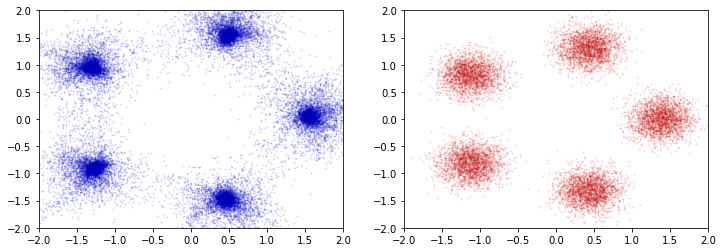

In [91]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.1, c='blue', edgecolors='black')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=2.3, alpha=0.2, c='red',  linewidths=0.1, edgecolors='black')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

We plot the flows from prior to data distribution:

In [75]:
traj = model[1].trajectory(Augmenter(1, 1)(sample.cuda()), s_span=torch.linspace(1,0,2)).detach().cpu() ; sample = sample.cpu()
traj = traj[:, :, 1:] # scrapping first dimension := jacobian trace

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 11.91 GiB total capacity; 7.37 GiB already allocated; 57.56 MiB free; 7.38 GiB reserved in total by PyTorch) (malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x46 (0x7fcd149d6536 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1cf1e (0x7fcd14c1ff1e in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1df9e (0x7fcd14c20f9e in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: THCStorage_resize + 0x96 (0x7fccbde4f186 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: at::native::(anonymous namespace)::resize_cuda_(at::Tensor&, c10::ArrayRef<long>, c10::optional<c10::MemoryFormat>) + 0x9aa (0x7fccbf665bfa in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0x288cb93 (0x7fccbf666b93 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xf21d92 (0x7fccbdcfbd92 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0x1053996 (0x7fccbde2d996 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #8: <unknown function> + 0xf76dc8 (0x7fccbdd50dc8 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0x10c3ec0 (0x7fccfa327ec0 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: <unknown function> + 0x2c9b6fe (0x7fccfbeff6fe in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x10c3ec0 (0x7fccfa327ec0 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::Tensor c10::Dispatcher::callUnboxed<at::Tensor, at::Tensor const&, at::Tensor const&>(c10::OperatorHandle const&, at::Tensor const&, at::Tensor const&) const + 0xb3 (0x7fcd15291d53 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #13: <unknown function> + 0x28ac337 (0x7fccfbb10337 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: torch::autograd::generated::AddmmBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x134 (0x7fccfbb4b004 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2d89c05 (0x7fccfbfedc05 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&) + 0x16f3 (0x7fccfbfeaf03 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&, bool) + 0x3d2 (0x7fccfbfebce2 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: torch::autograd::Engine::thread_init(int) + 0x39 (0x7fccfbfe4359 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: torch::autograd::python::PythonEngine::thread_init(int) + 0x38 (0x7fcd15555998 in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #20: <unknown function> + 0xee0f (0x7fcd16143e0f in /home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torch/_C.cpython-37m-x86_64-linux-gnu.so)
frame #21: <unknown function> + 0x76ba (0x7fcd2f4a56ba in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #22: clone + 0x6d (0x7fcd2e68841d in /lib/x86_64-linux-gnu/libc.so.6)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

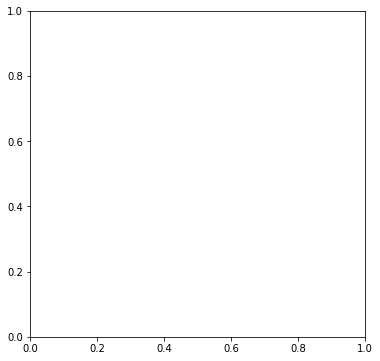

In [76]:
plt.figure(figsize=(6,6))
plt.scatter(sample[:100,0], sample[:100,1], s=10, alpha=0.8, c='black')
plt.scatter(traj[:,:100,0], traj[:,:100,1], s=4, alpha=0.4, c='g')
plt.scatter(traj[-1,:100,0], traj[-1,:100,1], s=4, alpha=1, c='red')
plt.legend(['Gaussian (prior) sample', 'Flow', 'End of the flow (new x)'])

In [221]:
def make_img(i):
    sample = prior.sample(torch.Size([2056]))
    # integrating from 1 to 0, 8 steps of rk4
    model[1].s_span = torch.linspace(1, 0, 2)
    new_x = model(sample).cpu().detach()
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(new_x[:,0], new_x[:,1], s=0.3, c='blue')
    #plt.scatter(boh[:,0], boh[:,1], s=0.3, c='black')

    plt.subplot(122)
    plt.scatter(X[:,0], X[:,1], s=0.3, c='red')
    plt.savefig(f'debug_img/{i}')

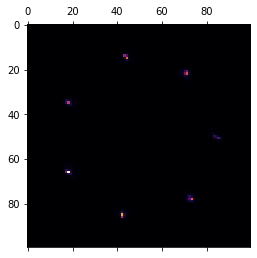

In [222]:
npts = 100
side = np.linspace(-2., 2., npts)
xx, yy = np.meshgrid(side, side)
memory= 100

x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
x = torch.from_numpy(x).type(torch.float32).to(device)

z, delta_logp = [], []
inds = torch.arange(0, x.shape[0]).to(torch.int64)
for ii in torch.split(inds, int(memory**2)):
    model[1].s_span = torch.linspace(0, 1, 2)
    z_full = model(x[ii]).cpu().detach()
    z_, delta_logp_ = z_full[:, 1:], z_full[:, 0]
    z.append(z_)
    delta_logp.append(delta_logp_)
z = torch.cat(z, 0)
delta_logp = torch.cat(delta_logp, 0)

#prior = prior.cpu()
logpz = prior.log_prob(z.cuda()).cpu()# logp(z)
logpx = logpz - delta_logp
px = np.exp(logpx.cpu().numpy()).reshape(npts, npts)
plt.matshow(px, cmap='inferno')

## FFJORD

In [ ]:
data = ToyDataset()
n_samples = 2056

X, yn = data.generate(n_samples, 'spirals', noise=0.5)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c='orange', alpha=0.3, s=4)

Great! You've seen how to train vanilla continuous normalizing flows in `torchdyn`. Next, we'll look at the *Free-form Jacobian of Reversible Dynamics* (FFJORD) variant proposed in [Grathwohl et al., 2018](https://arxiv.org/pdf/1810.01367.pdf).


Following tutorials will discuss regularization strategies to speed up CNF training, as those discussed for example in [this paper](https://arxiv.org/abs/2002.02798).